In [2]:
import csv
import time
import math
import numpy as np
import scipy.io
import pandas as pd
from matplotlib import pyplot as plt
from os import listdir
from os.path import dirname, join
from numpy import log, polyfit, sqrt, std, subtract
from hurst import compute_Hc
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa import stattools
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import pearsonr
from datetime import datetime
import sys

In [3]:
mat_files = listdir('E:/projects/connectome/data/FMRI_820subjects')
print("Total number of files found: "+str(len(mat_files)))

# loop through all files to extract ROI time-series from each subject and store in the tensor matrix subjects[]
subject_ts=[]
# define file directory
input_files_dir = 'E:/projects/connectome/data/FMRI_820subjects'
for mat_file in mat_files:
    file_name = join(input_files_dir,mat_file)
    temp = scipy.io.loadmat(file_name)  
    subject_ts.append(temp['tc'])
    
print("Total number of files loaded: "+str(len(subject_ts)))

Total number of files found: 820
Total number of files loaded: 820


In [4]:
# order_and_weight = models_weights[region] stores the weights of ARMA models for a subject
order_and_weight = [None for _ in range(len(subject_ts[0][0]))]
# Rscore = Rscore[region] stores the Pearson correlation between fitted ARMA models and original time-series
Rscore = [[None for _ in range(len(subject_ts[0][0]))] for _ in range(len(subject_ts))]
# ensemble_model = ensemble_model[region] stores the ensemble ARMA models for each resion
ensemble_ts = [None for _ in range(len(subject_ts[0][0]))] 
# Each of the model orders, paired with its model_weights as a tuple, Rscore and ensemble_model will be updated in each loop step and stored in files before they get updated

In [5]:
# Function computeWeights compute the corresponding model weights with their AIC scores
def computeWeights(AIC):
    min_AIC = min(AIC)
    AIC = np.array(AIC)
    prob = []
    for i in range(len(AIC)):
        prob.append(math.exp((min_AIC-AIC[i])/2))
    prob = np.array(prob)
    return prob/sum(prob)

def computeEnsemble(models,weights):
    ensemble=np.array([0 for _ in range(len(models[0]))])
    for i in range(len(models)):
        ensemble = ensemble + np.array(models[i])*weights[i]
    return list(ensemble)

In [ ]:
d = 0 # Due to stationarity test results our time-series are stationary (possibly with fractional integration order) so we do not difference
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print('Computation started at '+ str(current_time))
p_max = 6
q_max = 6
for sub in range(40): # only 41 subjects in each stack
    for reg in range(0,20):
        ts = subject_ts[sub][:,reg]
        PACF=stattools.pacf(ts) # use partial auto-correlation to determine the differencing order
        if abs(PACF[1])>0.2:
            d=1 # if the lag-1 autocorrelation is strong, take an order 1-differencing
        else:
            d=0
        predictions = [] # a 2D array that stores the predicted values of all fitted models
        AIC = [] # an 1D array that stores AIC scores
        orders = []
        for p in range(1,p_max):
            for q in range(0,q_max):
                try:
                    fitted_model = SARIMAX(ts,order=(p,d,q),enforce_invertibility=False).fit(disp=-1)
                    predictions.append(fitted_model.predict())
                    orders.append((p,d,q))
                    AIC.append(fitted_model.aic)
                    weights = computeWeights(AIC)
                    orders_and_weights = (orders, weights)    
                    print("finished fitting model for subject {} region {} with (p,d,q)=({},{},{})".format(sub, reg,p,d,q))
                except:
                    print("failed to fit model for subject {} region {} with (p,d,q)=({},{},{})".format(sub, reg,p,d,q))
                    continue
        
        ensemble = computeEnsemble(predictions,weights)
        Rscore[sub][reg] = pearsonr(ensemble,ts)[0]
        
        order_and_weight[reg] = orders_and_weights
        ensemble_ts[reg] = ensemble
        
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print('subject {} region {} finished at {}'.format(sub,reg,str(current_time)))

Computation started at 13:10:04
finished fitting model for subject 0 region 0 with (p,d,q)=(1,1,0)
finished fitting model for subject 0 region 0 with (p,d,q)=(1,1,1)
finished fitting model for subject 0 region 0 with (p,d,q)=(1,1,2)
finished fitting model for subject 0 region 0 with (p,d,q)=(1,1,3)
finished fitting model for subject 0 region 0 with (p,d,q)=(1,1,4)
finished fitting model for subject 0 region 0 with (p,d,q)=(1,1,5)
finished fitting model for subject 0 region 0 with (p,d,q)=(2,1,0)
finished fitting model for subject 0 region 0 with (p,d,q)=(2,1,1)
finished fitting model for subject 0 region 0 with (p,d,q)=(2,1,2)
finished fitting model for subject 0 region 0 with (p,d,q)=(2,1,3)
finished fitting model for subject 0 region 0 with (p,d,q)=(2,1,4)
finished fitting model for subject 0 region 0 with (p,d,q)=(2,1,5)
finished fitting model for subject 0 region 0 with (p,d,q)=(3,1,0)
finished fitting model for subject 0 region 0 with (p,d,q)=(3,1,1)
finished fitting model for sub

finished fitting model for subject 0 region 4 with (p,d,q)=(1,0,1)
finished fitting model for subject 0 region 4 with (p,d,q)=(1,0,2)
finished fitting model for subject 0 region 4 with (p,d,q)=(1,0,3)
finished fitting model for subject 0 region 4 with (p,d,q)=(1,0,4)
finished fitting model for subject 0 region 4 with (p,d,q)=(1,0,5)
finished fitting model for subject 0 region 4 with (p,d,q)=(2,0,0)
finished fitting model for subject 0 region 4 with (p,d,q)=(2,0,1)
finished fitting model for subject 0 region 4 with (p,d,q)=(2,0,2)
finished fitting model for subject 0 region 4 with (p,d,q)=(2,0,3)
finished fitting model for subject 0 region 4 with (p,d,q)=(2,0,4)
finished fitting model for subject 0 region 4 with (p,d,q)=(2,0,5)
finished fitting model for subject 0 region 4 with (p,d,q)=(3,0,0)
finished fitting model for subject 0 region 4 with (p,d,q)=(3,0,1)
finished fitting model for subject 0 region 4 with (p,d,q)=(3,0,2)
finished fitting model for subject 0 region 4 with (p,d,q)=(3,

finished fitting model for subject 0 region 8 with (p,d,q)=(1,1,2)
finished fitting model for subject 0 region 8 with (p,d,q)=(1,1,3)
finished fitting model for subject 0 region 8 with (p,d,q)=(1,1,4)
finished fitting model for subject 0 region 8 with (p,d,q)=(1,1,5)
finished fitting model for subject 0 region 8 with (p,d,q)=(2,1,0)
finished fitting model for subject 0 region 8 with (p,d,q)=(2,1,1)
finished fitting model for subject 0 region 8 with (p,d,q)=(2,1,2)
finished fitting model for subject 0 region 8 with (p,d,q)=(2,1,3)
finished fitting model for subject 0 region 8 with (p,d,q)=(2,1,4)
finished fitting model for subject 0 region 8 with (p,d,q)=(2,1,5)
finished fitting model for subject 0 region 8 with (p,d,q)=(3,1,0)
finished fitting model for subject 0 region 8 with (p,d,q)=(3,1,1)
finished fitting model for subject 0 region 8 with (p,d,q)=(3,1,2)
finished fitting model for subject 0 region 8 with (p,d,q)=(3,1,3)
finished fitting model for subject 0 region 8 with (p,d,q)=(3,

finished fitting model for subject 0 region 12 with (p,d,q)=(1,1,1)
finished fitting model for subject 0 region 12 with (p,d,q)=(1,1,2)
finished fitting model for subject 0 region 12 with (p,d,q)=(1,1,3)
finished fitting model for subject 0 region 12 with (p,d,q)=(1,1,4)
finished fitting model for subject 0 region 12 with (p,d,q)=(1,1,5)
finished fitting model for subject 0 region 12 with (p,d,q)=(2,1,0)
finished fitting model for subject 0 region 12 with (p,d,q)=(2,1,1)
finished fitting model for subject 0 region 12 with (p,d,q)=(2,1,2)
finished fitting model for subject 0 region 12 with (p,d,q)=(2,1,3)
finished fitting model for subject 0 region 12 with (p,d,q)=(2,1,4)
finished fitting model for subject 0 region 12 with (p,d,q)=(2,1,5)
finished fitting model for subject 0 region 12 with (p,d,q)=(3,1,0)
finished fitting model for subject 0 region 12 with (p,d,q)=(3,1,1)
finished fitting model for subject 0 region 12 with (p,d,q)=(3,1,2)
finished fitting model for subject 0 region 12 w

finished fitting model for subject 0 region 16 with (p,d,q)=(1,0,1)
finished fitting model for subject 0 region 16 with (p,d,q)=(1,0,2)
finished fitting model for subject 0 region 16 with (p,d,q)=(1,0,3)
finished fitting model for subject 0 region 16 with (p,d,q)=(1,0,4)
finished fitting model for subject 0 region 16 with (p,d,q)=(1,0,5)
finished fitting model for subject 0 region 16 with (p,d,q)=(2,0,0)
finished fitting model for subject 0 region 16 with (p,d,q)=(2,0,1)
finished fitting model for subject 0 region 16 with (p,d,q)=(2,0,2)
finished fitting model for subject 0 region 16 with (p,d,q)=(2,0,3)
finished fitting model for subject 0 region 16 with (p,d,q)=(2,0,4)
finished fitting model for subject 0 region 16 with (p,d,q)=(2,0,5)
finished fitting model for subject 0 region 16 with (p,d,q)=(3,0,0)
finished fitting model for subject 0 region 16 with (p,d,q)=(3,0,1)
finished fitting model for subject 0 region 16 with (p,d,q)=(3,0,2)
finished fitting model for subject 0 region 16 w

finished fitting model for subject 1 region 0 with (p,d,q)=(1,0,1)
finished fitting model for subject 1 region 0 with (p,d,q)=(1,0,2)
finished fitting model for subject 1 region 0 with (p,d,q)=(1,0,3)
finished fitting model for subject 1 region 0 with (p,d,q)=(1,0,4)
finished fitting model for subject 1 region 0 with (p,d,q)=(1,0,5)
finished fitting model for subject 1 region 0 with (p,d,q)=(2,0,0)
finished fitting model for subject 1 region 0 with (p,d,q)=(2,0,1)
finished fitting model for subject 1 region 0 with (p,d,q)=(2,0,2)
finished fitting model for subject 1 region 0 with (p,d,q)=(2,0,3)
finished fitting model for subject 1 region 0 with (p,d,q)=(2,0,4)
finished fitting model for subject 1 region 0 with (p,d,q)=(2,0,5)
finished fitting model for subject 1 region 0 with (p,d,q)=(3,0,0)
finished fitting model for subject 1 region 0 with (p,d,q)=(3,0,1)
finished fitting model for subject 1 region 0 with (p,d,q)=(3,0,2)
finished fitting model for subject 1 region 0 with (p,d,q)=(3,

finished fitting model for subject 1 region 4 with (p,d,q)=(1,0,1)
finished fitting model for subject 1 region 4 with (p,d,q)=(1,0,2)
finished fitting model for subject 1 region 4 with (p,d,q)=(1,0,3)
finished fitting model for subject 1 region 4 with (p,d,q)=(1,0,4)
finished fitting model for subject 1 region 4 with (p,d,q)=(1,0,5)
finished fitting model for subject 1 region 4 with (p,d,q)=(2,0,0)
finished fitting model for subject 1 region 4 with (p,d,q)=(2,0,1)
finished fitting model for subject 1 region 4 with (p,d,q)=(2,0,2)
finished fitting model for subject 1 region 4 with (p,d,q)=(2,0,3)
finished fitting model for subject 1 region 4 with (p,d,q)=(2,0,4)
finished fitting model for subject 1 region 4 with (p,d,q)=(2,0,5)
finished fitting model for subject 1 region 4 with (p,d,q)=(3,0,0)
finished fitting model for subject 1 region 4 with (p,d,q)=(3,0,1)
finished fitting model for subject 1 region 4 with (p,d,q)=(3,0,2)
finished fitting model for subject 1 region 4 with (p,d,q)=(3,

finished fitting model for subject 1 region 8 with (p,d,q)=(1,0,2)
finished fitting model for subject 1 region 8 with (p,d,q)=(1,0,3)
finished fitting model for subject 1 region 8 with (p,d,q)=(1,0,4)
finished fitting model for subject 1 region 8 with (p,d,q)=(1,0,5)
finished fitting model for subject 1 region 8 with (p,d,q)=(2,0,0)
finished fitting model for subject 1 region 8 with (p,d,q)=(2,0,1)
finished fitting model for subject 1 region 8 with (p,d,q)=(2,0,2)
finished fitting model for subject 1 region 8 with (p,d,q)=(2,0,3)
finished fitting model for subject 1 region 8 with (p,d,q)=(2,0,4)
finished fitting model for subject 1 region 8 with (p,d,q)=(2,0,5)
finished fitting model for subject 1 region 8 with (p,d,q)=(3,0,0)
finished fitting model for subject 1 region 8 with (p,d,q)=(3,0,1)
finished fitting model for subject 1 region 8 with (p,d,q)=(3,0,2)
finished fitting model for subject 1 region 8 with (p,d,q)=(3,0,3)
finished fitting model for subject 1 region 8 with (p,d,q)=(3,

finished fitting model for subject 1 region 12 with (p,d,q)=(1,0,1)
finished fitting model for subject 1 region 12 with (p,d,q)=(1,0,2)
finished fitting model for subject 1 region 12 with (p,d,q)=(1,0,3)
finished fitting model for subject 1 region 12 with (p,d,q)=(1,0,4)
finished fitting model for subject 1 region 12 with (p,d,q)=(1,0,5)
finished fitting model for subject 1 region 12 with (p,d,q)=(2,0,0)
finished fitting model for subject 1 region 12 with (p,d,q)=(2,0,1)
finished fitting model for subject 1 region 12 with (p,d,q)=(2,0,2)
finished fitting model for subject 1 region 12 with (p,d,q)=(2,0,3)
finished fitting model for subject 1 region 12 with (p,d,q)=(2,0,4)
finished fitting model for subject 1 region 12 with (p,d,q)=(2,0,5)
finished fitting model for subject 1 region 12 with (p,d,q)=(3,0,0)
finished fitting model for subject 1 region 12 with (p,d,q)=(3,0,1)
finished fitting model for subject 1 region 12 with (p,d,q)=(3,0,2)
finished fitting model for subject 1 region 12 w

finished fitting model for subject 1 region 16 with (p,d,q)=(1,0,2)
finished fitting model for subject 1 region 16 with (p,d,q)=(1,0,3)
finished fitting model for subject 1 region 16 with (p,d,q)=(1,0,4)
finished fitting model for subject 1 region 16 with (p,d,q)=(1,0,5)
finished fitting model for subject 1 region 16 with (p,d,q)=(2,0,0)
finished fitting model for subject 1 region 16 with (p,d,q)=(2,0,1)
finished fitting model for subject 1 region 16 with (p,d,q)=(2,0,2)
finished fitting model for subject 1 region 16 with (p,d,q)=(2,0,3)
finished fitting model for subject 1 region 16 with (p,d,q)=(2,0,4)
finished fitting model for subject 1 region 16 with (p,d,q)=(2,0,5)
finished fitting model for subject 1 region 16 with (p,d,q)=(3,0,0)
finished fitting model for subject 1 region 16 with (p,d,q)=(3,0,1)
finished fitting model for subject 1 region 16 with (p,d,q)=(3,0,2)
finished fitting model for subject 1 region 16 with (p,d,q)=(3,0,3)
finished fitting model for subject 1 region 16 w

finished fitting model for subject 2 region 0 with (p,d,q)=(1,1,2)
finished fitting model for subject 2 region 0 with (p,d,q)=(1,1,3)
finished fitting model for subject 2 region 0 with (p,d,q)=(1,1,4)
finished fitting model for subject 2 region 0 with (p,d,q)=(1,1,5)
finished fitting model for subject 2 region 0 with (p,d,q)=(2,1,0)
finished fitting model for subject 2 region 0 with (p,d,q)=(2,1,1)
finished fitting model for subject 2 region 0 with (p,d,q)=(2,1,2)
finished fitting model for subject 2 region 0 with (p,d,q)=(2,1,3)
finished fitting model for subject 2 region 0 with (p,d,q)=(2,1,4)
finished fitting model for subject 2 region 0 with (p,d,q)=(2,1,5)
finished fitting model for subject 2 region 0 with (p,d,q)=(3,1,0)
finished fitting model for subject 2 region 0 with (p,d,q)=(3,1,1)
finished fitting model for subject 2 region 0 with (p,d,q)=(3,1,2)
finished fitting model for subject 2 region 0 with (p,d,q)=(3,1,3)
finished fitting model for subject 2 region 0 with (p,d,q)=(3,

finished fitting model for subject 2 region 4 with (p,d,q)=(1,1,2)
finished fitting model for subject 2 region 4 with (p,d,q)=(1,1,3)
finished fitting model for subject 2 region 4 with (p,d,q)=(1,1,4)
finished fitting model for subject 2 region 4 with (p,d,q)=(1,1,5)
finished fitting model for subject 2 region 4 with (p,d,q)=(2,1,0)
finished fitting model for subject 2 region 4 with (p,d,q)=(2,1,1)
finished fitting model for subject 2 region 4 with (p,d,q)=(2,1,2)
finished fitting model for subject 2 region 4 with (p,d,q)=(2,1,3)
finished fitting model for subject 2 region 4 with (p,d,q)=(2,1,4)
finished fitting model for subject 2 region 4 with (p,d,q)=(2,1,5)
finished fitting model for subject 2 region 4 with (p,d,q)=(3,1,0)
finished fitting model for subject 2 region 4 with (p,d,q)=(3,1,1)
finished fitting model for subject 2 region 4 with (p,d,q)=(3,1,2)
finished fitting model for subject 2 region 4 with (p,d,q)=(3,1,3)
finished fitting model for subject 2 region 4 with (p,d,q)=(3,

finished fitting model for subject 2 region 8 with (p,d,q)=(1,1,2)
finished fitting model for subject 2 region 8 with (p,d,q)=(1,1,3)
finished fitting model for subject 2 region 8 with (p,d,q)=(1,1,4)
finished fitting model for subject 2 region 8 with (p,d,q)=(1,1,5)
finished fitting model for subject 2 region 8 with (p,d,q)=(2,1,0)
finished fitting model for subject 2 region 8 with (p,d,q)=(2,1,1)
finished fitting model for subject 2 region 8 with (p,d,q)=(2,1,2)
finished fitting model for subject 2 region 8 with (p,d,q)=(2,1,3)
finished fitting model for subject 2 region 8 with (p,d,q)=(2,1,4)
finished fitting model for subject 2 region 8 with (p,d,q)=(2,1,5)
finished fitting model for subject 2 region 8 with (p,d,q)=(3,1,0)
finished fitting model for subject 2 region 8 with (p,d,q)=(3,1,1)
finished fitting model for subject 2 region 8 with (p,d,q)=(3,1,2)
finished fitting model for subject 2 region 8 with (p,d,q)=(3,1,3)
finished fitting model for subject 2 region 8 with (p,d,q)=(3,

finished fitting model for subject 2 region 12 with (p,d,q)=(1,0,2)
finished fitting model for subject 2 region 12 with (p,d,q)=(1,0,3)
finished fitting model for subject 2 region 12 with (p,d,q)=(1,0,4)
finished fitting model for subject 2 region 12 with (p,d,q)=(1,0,5)
finished fitting model for subject 2 region 12 with (p,d,q)=(2,0,0)
finished fitting model for subject 2 region 12 with (p,d,q)=(2,0,1)
finished fitting model for subject 2 region 12 with (p,d,q)=(2,0,2)
finished fitting model for subject 2 region 12 with (p,d,q)=(2,0,3)
finished fitting model for subject 2 region 12 with (p,d,q)=(2,0,4)
finished fitting model for subject 2 region 12 with (p,d,q)=(2,0,5)
finished fitting model for subject 2 region 12 with (p,d,q)=(3,0,0)
finished fitting model for subject 2 region 12 with (p,d,q)=(3,0,1)
finished fitting model for subject 2 region 12 with (p,d,q)=(3,0,2)
finished fitting model for subject 2 region 12 with (p,d,q)=(3,0,3)
finished fitting model for subject 2 region 12 w

finished fitting model for subject 2 region 16 with (p,d,q)=(1,1,1)
finished fitting model for subject 2 region 16 with (p,d,q)=(1,1,2)
finished fitting model for subject 2 region 16 with (p,d,q)=(1,1,3)
finished fitting model for subject 2 region 16 with (p,d,q)=(1,1,4)
finished fitting model for subject 2 region 16 with (p,d,q)=(1,1,5)
finished fitting model for subject 2 region 16 with (p,d,q)=(2,1,0)
finished fitting model for subject 2 region 16 with (p,d,q)=(2,1,1)
finished fitting model for subject 2 region 16 with (p,d,q)=(2,1,2)
finished fitting model for subject 2 region 16 with (p,d,q)=(2,1,3)
finished fitting model for subject 2 region 16 with (p,d,q)=(2,1,4)
finished fitting model for subject 2 region 16 with (p,d,q)=(2,1,5)
finished fitting model for subject 2 region 16 with (p,d,q)=(3,1,0)
finished fitting model for subject 2 region 16 with (p,d,q)=(3,1,1)
finished fitting model for subject 2 region 16 with (p,d,q)=(3,1,2)
finished fitting model for subject 2 region 16 w

finished fitting model for subject 3 region 0 with (p,d,q)=(1,1,2)
finished fitting model for subject 3 region 0 with (p,d,q)=(1,1,3)
finished fitting model for subject 3 region 0 with (p,d,q)=(1,1,4)
finished fitting model for subject 3 region 0 with (p,d,q)=(1,1,5)
finished fitting model for subject 3 region 0 with (p,d,q)=(2,1,0)
finished fitting model for subject 3 region 0 with (p,d,q)=(2,1,1)
finished fitting model for subject 3 region 0 with (p,d,q)=(2,1,2)
finished fitting model for subject 3 region 0 with (p,d,q)=(2,1,3)
finished fitting model for subject 3 region 0 with (p,d,q)=(2,1,4)
finished fitting model for subject 3 region 0 with (p,d,q)=(2,1,5)
finished fitting model for subject 3 region 0 with (p,d,q)=(3,1,0)
finished fitting model for subject 3 region 0 with (p,d,q)=(3,1,1)
finished fitting model for subject 3 region 0 with (p,d,q)=(3,1,2)
finished fitting model for subject 3 region 0 with (p,d,q)=(3,1,3)
finished fitting model for subject 3 region 0 with (p,d,q)=(3,

finished fitting model for subject 3 region 4 with (p,d,q)=(1,0,2)
finished fitting model for subject 3 region 4 with (p,d,q)=(1,0,3)
finished fitting model for subject 3 region 4 with (p,d,q)=(1,0,4)
finished fitting model for subject 3 region 4 with (p,d,q)=(1,0,5)
finished fitting model for subject 3 region 4 with (p,d,q)=(2,0,0)
finished fitting model for subject 3 region 4 with (p,d,q)=(2,0,1)
finished fitting model for subject 3 region 4 with (p,d,q)=(2,0,2)
finished fitting model for subject 3 region 4 with (p,d,q)=(2,0,3)
finished fitting model for subject 3 region 4 with (p,d,q)=(2,0,4)
finished fitting model for subject 3 region 4 with (p,d,q)=(2,0,5)
finished fitting model for subject 3 region 4 with (p,d,q)=(3,0,0)
finished fitting model for subject 3 region 4 with (p,d,q)=(3,0,1)
finished fitting model for subject 3 region 4 with (p,d,q)=(3,0,2)
finished fitting model for subject 3 region 4 with (p,d,q)=(3,0,3)
finished fitting model for subject 3 region 4 with (p,d,q)=(3,

finished fitting model for subject 3 region 8 with (p,d,q)=(1,1,1)
finished fitting model for subject 3 region 8 with (p,d,q)=(1,1,2)
finished fitting model for subject 3 region 8 with (p,d,q)=(1,1,3)
finished fitting model for subject 3 region 8 with (p,d,q)=(1,1,4)
finished fitting model for subject 3 region 8 with (p,d,q)=(1,1,5)
finished fitting model for subject 3 region 8 with (p,d,q)=(2,1,0)
finished fitting model for subject 3 region 8 with (p,d,q)=(2,1,1)
finished fitting model for subject 3 region 8 with (p,d,q)=(2,1,2)
finished fitting model for subject 3 region 8 with (p,d,q)=(2,1,3)
finished fitting model for subject 3 region 8 with (p,d,q)=(2,1,4)
finished fitting model for subject 3 region 8 with (p,d,q)=(2,1,5)
finished fitting model for subject 3 region 8 with (p,d,q)=(3,1,0)
finished fitting model for subject 3 region 8 with (p,d,q)=(3,1,1)
finished fitting model for subject 3 region 8 with (p,d,q)=(3,1,2)
finished fitting model for subject 3 region 8 with (p,d,q)=(3,

finished fitting model for subject 3 region 12 with (p,d,q)=(1,1,2)
finished fitting model for subject 3 region 12 with (p,d,q)=(1,1,3)
finished fitting model for subject 3 region 12 with (p,d,q)=(1,1,4)
finished fitting model for subject 3 region 12 with (p,d,q)=(1,1,5)
finished fitting model for subject 3 region 12 with (p,d,q)=(2,1,0)
finished fitting model for subject 3 region 12 with (p,d,q)=(2,1,1)
finished fitting model for subject 3 region 12 with (p,d,q)=(2,1,2)
finished fitting model for subject 3 region 12 with (p,d,q)=(2,1,3)
finished fitting model for subject 3 region 12 with (p,d,q)=(2,1,4)
finished fitting model for subject 3 region 12 with (p,d,q)=(2,1,5)
finished fitting model for subject 3 region 12 with (p,d,q)=(3,1,0)
finished fitting model for subject 3 region 12 with (p,d,q)=(3,1,1)
finished fitting model for subject 3 region 12 with (p,d,q)=(3,1,2)
finished fitting model for subject 3 region 12 with (p,d,q)=(3,1,3)
finished fitting model for subject 3 region 12 w

finished fitting model for subject 3 region 16 with (p,d,q)=(1,1,2)
finished fitting model for subject 3 region 16 with (p,d,q)=(1,1,3)
finished fitting model for subject 3 region 16 with (p,d,q)=(1,1,4)
finished fitting model for subject 3 region 16 with (p,d,q)=(1,1,5)
finished fitting model for subject 3 region 16 with (p,d,q)=(2,1,0)
finished fitting model for subject 3 region 16 with (p,d,q)=(2,1,1)
finished fitting model for subject 3 region 16 with (p,d,q)=(2,1,2)
finished fitting model for subject 3 region 16 with (p,d,q)=(2,1,3)
finished fitting model for subject 3 region 16 with (p,d,q)=(2,1,4)
finished fitting model for subject 3 region 16 with (p,d,q)=(2,1,5)
finished fitting model for subject 3 region 16 with (p,d,q)=(3,1,0)
finished fitting model for subject 3 region 16 with (p,d,q)=(3,1,1)
finished fitting model for subject 3 region 16 with (p,d,q)=(3,1,2)
finished fitting model for subject 3 region 16 with (p,d,q)=(3,1,3)
finished fitting model for subject 3 region 16 w

finished fitting model for subject 4 region 0 with (p,d,q)=(1,0,1)
finished fitting model for subject 4 region 0 with (p,d,q)=(1,0,2)
finished fitting model for subject 4 region 0 with (p,d,q)=(1,0,3)
finished fitting model for subject 4 region 0 with (p,d,q)=(1,0,4)
finished fitting model for subject 4 region 0 with (p,d,q)=(1,0,5)
finished fitting model for subject 4 region 0 with (p,d,q)=(2,0,0)
finished fitting model for subject 4 region 0 with (p,d,q)=(2,0,1)
finished fitting model for subject 4 region 0 with (p,d,q)=(2,0,2)
finished fitting model for subject 4 region 0 with (p,d,q)=(2,0,3)
finished fitting model for subject 4 region 0 with (p,d,q)=(2,0,4)
finished fitting model for subject 4 region 0 with (p,d,q)=(2,0,5)
finished fitting model for subject 4 region 0 with (p,d,q)=(3,0,0)
finished fitting model for subject 4 region 0 with (p,d,q)=(3,0,1)
finished fitting model for subject 4 region 0 with (p,d,q)=(3,0,2)
finished fitting model for subject 4 region 0 with (p,d,q)=(3,

finished fitting model for subject 4 region 4 with (p,d,q)=(1,1,2)
finished fitting model for subject 4 region 4 with (p,d,q)=(1,1,3)
finished fitting model for subject 4 region 4 with (p,d,q)=(1,1,4)
finished fitting model for subject 4 region 4 with (p,d,q)=(1,1,5)
finished fitting model for subject 4 region 4 with (p,d,q)=(2,1,0)
finished fitting model for subject 4 region 4 with (p,d,q)=(2,1,1)
finished fitting model for subject 4 region 4 with (p,d,q)=(2,1,2)
finished fitting model for subject 4 region 4 with (p,d,q)=(2,1,3)
finished fitting model for subject 4 region 4 with (p,d,q)=(2,1,4)
finished fitting model for subject 4 region 4 with (p,d,q)=(2,1,5)
finished fitting model for subject 4 region 4 with (p,d,q)=(3,1,0)
finished fitting model for subject 4 region 4 with (p,d,q)=(3,1,1)
finished fitting model for subject 4 region 4 with (p,d,q)=(3,1,2)
finished fitting model for subject 4 region 4 with (p,d,q)=(3,1,3)
finished fitting model for subject 4 region 4 with (p,d,q)=(3,

finished fitting model for subject 4 region 8 with (p,d,q)=(1,1,2)
finished fitting model for subject 4 region 8 with (p,d,q)=(1,1,3)
finished fitting model for subject 4 region 8 with (p,d,q)=(1,1,4)
finished fitting model for subject 4 region 8 with (p,d,q)=(1,1,5)
finished fitting model for subject 4 region 8 with (p,d,q)=(2,1,0)
finished fitting model for subject 4 region 8 with (p,d,q)=(2,1,1)
finished fitting model for subject 4 region 8 with (p,d,q)=(2,1,2)
finished fitting model for subject 4 region 8 with (p,d,q)=(2,1,3)
finished fitting model for subject 4 region 8 with (p,d,q)=(2,1,4)
finished fitting model for subject 4 region 8 with (p,d,q)=(2,1,5)
finished fitting model for subject 4 region 8 with (p,d,q)=(3,1,0)
finished fitting model for subject 4 region 8 with (p,d,q)=(3,1,1)
finished fitting model for subject 4 region 8 with (p,d,q)=(3,1,2)
finished fitting model for subject 4 region 8 with (p,d,q)=(3,1,3)
finished fitting model for subject 4 region 8 with (p,d,q)=(3,

finished fitting model for subject 4 region 12 with (p,d,q)=(1,0,1)
finished fitting model for subject 4 region 12 with (p,d,q)=(1,0,2)
finished fitting model for subject 4 region 12 with (p,d,q)=(1,0,3)
finished fitting model for subject 4 region 12 with (p,d,q)=(1,0,4)
finished fitting model for subject 4 region 12 with (p,d,q)=(1,0,5)
finished fitting model for subject 4 region 12 with (p,d,q)=(2,0,0)
finished fitting model for subject 4 region 12 with (p,d,q)=(2,0,1)
finished fitting model for subject 4 region 12 with (p,d,q)=(2,0,2)
finished fitting model for subject 4 region 12 with (p,d,q)=(2,0,3)
finished fitting model for subject 4 region 12 with (p,d,q)=(2,0,4)
finished fitting model for subject 4 region 12 with (p,d,q)=(2,0,5)
finished fitting model for subject 4 region 12 with (p,d,q)=(3,0,0)
finished fitting model for subject 4 region 12 with (p,d,q)=(3,0,1)
finished fitting model for subject 4 region 12 with (p,d,q)=(3,0,2)
finished fitting model for subject 4 region 12 w

finished fitting model for subject 4 region 16 with (p,d,q)=(1,0,2)
finished fitting model for subject 4 region 16 with (p,d,q)=(1,0,3)
finished fitting model for subject 4 region 16 with (p,d,q)=(1,0,4)
finished fitting model for subject 4 region 16 with (p,d,q)=(1,0,5)
finished fitting model for subject 4 region 16 with (p,d,q)=(2,0,0)
finished fitting model for subject 4 region 16 with (p,d,q)=(2,0,1)
finished fitting model for subject 4 region 16 with (p,d,q)=(2,0,2)
finished fitting model for subject 4 region 16 with (p,d,q)=(2,0,3)
finished fitting model for subject 4 region 16 with (p,d,q)=(2,0,4)
finished fitting model for subject 4 region 16 with (p,d,q)=(2,0,5)
finished fitting model for subject 4 region 16 with (p,d,q)=(3,0,0)
finished fitting model for subject 4 region 16 with (p,d,q)=(3,0,1)
finished fitting model for subject 4 region 16 with (p,d,q)=(3,0,2)
finished fitting model for subject 4 region 16 with (p,d,q)=(3,0,3)
finished fitting model for subject 4 region 16 w

finished fitting model for subject 5 region 0 with (p,d,q)=(1,1,1)
finished fitting model for subject 5 region 0 with (p,d,q)=(1,1,2)
finished fitting model for subject 5 region 0 with (p,d,q)=(1,1,3)
finished fitting model for subject 5 region 0 with (p,d,q)=(1,1,4)
finished fitting model for subject 5 region 0 with (p,d,q)=(1,1,5)
finished fitting model for subject 5 region 0 with (p,d,q)=(2,1,0)
finished fitting model for subject 5 region 0 with (p,d,q)=(2,1,1)
finished fitting model for subject 5 region 0 with (p,d,q)=(2,1,2)
finished fitting model for subject 5 region 0 with (p,d,q)=(2,1,3)
finished fitting model for subject 5 region 0 with (p,d,q)=(2,1,4)
finished fitting model for subject 5 region 0 with (p,d,q)=(2,1,5)
finished fitting model for subject 5 region 0 with (p,d,q)=(3,1,0)
finished fitting model for subject 5 region 0 with (p,d,q)=(3,1,1)
finished fitting model for subject 5 region 0 with (p,d,q)=(3,1,2)
finished fitting model for subject 5 region 0 with (p,d,q)=(3,

finished fitting model for subject 5 region 4 with (p,d,q)=(1,1,2)
finished fitting model for subject 5 region 4 with (p,d,q)=(1,1,3)
finished fitting model for subject 5 region 4 with (p,d,q)=(1,1,4)
finished fitting model for subject 5 region 4 with (p,d,q)=(1,1,5)
finished fitting model for subject 5 region 4 with (p,d,q)=(2,1,0)
finished fitting model for subject 5 region 4 with (p,d,q)=(2,1,1)
finished fitting model for subject 5 region 4 with (p,d,q)=(2,1,2)
finished fitting model for subject 5 region 4 with (p,d,q)=(2,1,3)
finished fitting model for subject 5 region 4 with (p,d,q)=(2,1,4)
finished fitting model for subject 5 region 4 with (p,d,q)=(2,1,5)
finished fitting model for subject 5 region 4 with (p,d,q)=(3,1,0)
finished fitting model for subject 5 region 4 with (p,d,q)=(3,1,1)
finished fitting model for subject 5 region 4 with (p,d,q)=(3,1,2)
finished fitting model for subject 5 region 4 with (p,d,q)=(3,1,3)
finished fitting model for subject 5 region 4 with (p,d,q)=(3,

finished fitting model for subject 5 region 8 with (p,d,q)=(1,1,2)
finished fitting model for subject 5 region 8 with (p,d,q)=(1,1,3)
finished fitting model for subject 5 region 8 with (p,d,q)=(1,1,4)
finished fitting model for subject 5 region 8 with (p,d,q)=(1,1,5)
finished fitting model for subject 5 region 8 with (p,d,q)=(2,1,0)
finished fitting model for subject 5 region 8 with (p,d,q)=(2,1,1)
finished fitting model for subject 5 region 8 with (p,d,q)=(2,1,2)
finished fitting model for subject 5 region 8 with (p,d,q)=(2,1,3)
finished fitting model for subject 5 region 8 with (p,d,q)=(2,1,4)
finished fitting model for subject 5 region 8 with (p,d,q)=(2,1,5)
finished fitting model for subject 5 region 8 with (p,d,q)=(3,1,0)
finished fitting model for subject 5 region 8 with (p,d,q)=(3,1,1)
finished fitting model for subject 5 region 8 with (p,d,q)=(3,1,2)
finished fitting model for subject 5 region 8 with (p,d,q)=(3,1,3)
finished fitting model for subject 5 region 8 with (p,d,q)=(3,

finished fitting model for subject 5 region 12 with (p,d,q)=(1,1,2)
finished fitting model for subject 5 region 12 with (p,d,q)=(1,1,3)
finished fitting model for subject 5 region 12 with (p,d,q)=(1,1,4)
finished fitting model for subject 5 region 12 with (p,d,q)=(1,1,5)
finished fitting model for subject 5 region 12 with (p,d,q)=(2,1,0)
finished fitting model for subject 5 region 12 with (p,d,q)=(2,1,1)
finished fitting model for subject 5 region 12 with (p,d,q)=(2,1,2)
finished fitting model for subject 5 region 12 with (p,d,q)=(2,1,3)
finished fitting model for subject 5 region 12 with (p,d,q)=(2,1,4)
finished fitting model for subject 5 region 12 with (p,d,q)=(2,1,5)
finished fitting model for subject 5 region 12 with (p,d,q)=(3,1,0)
finished fitting model for subject 5 region 12 with (p,d,q)=(3,1,1)
finished fitting model for subject 5 region 12 with (p,d,q)=(3,1,2)
finished fitting model for subject 5 region 12 with (p,d,q)=(3,1,3)
finished fitting model for subject 5 region 12 w

finished fitting model for subject 5 region 16 with (p,d,q)=(1,0,1)
finished fitting model for subject 5 region 16 with (p,d,q)=(1,0,2)
finished fitting model for subject 5 region 16 with (p,d,q)=(1,0,3)
finished fitting model for subject 5 region 16 with (p,d,q)=(1,0,4)
finished fitting model for subject 5 region 16 with (p,d,q)=(1,0,5)
finished fitting model for subject 5 region 16 with (p,d,q)=(2,0,0)
finished fitting model for subject 5 region 16 with (p,d,q)=(2,0,1)
finished fitting model for subject 5 region 16 with (p,d,q)=(2,0,2)
finished fitting model for subject 5 region 16 with (p,d,q)=(2,0,3)
finished fitting model for subject 5 region 16 with (p,d,q)=(2,0,4)
finished fitting model for subject 5 region 16 with (p,d,q)=(2,0,5)
finished fitting model for subject 5 region 16 with (p,d,q)=(3,0,0)
finished fitting model for subject 5 region 16 with (p,d,q)=(3,0,1)
finished fitting model for subject 5 region 16 with (p,d,q)=(3,0,2)
finished fitting model for subject 5 region 16 w

finished fitting model for subject 6 region 0 with (p,d,q)=(1,1,2)
finished fitting model for subject 6 region 0 with (p,d,q)=(1,1,3)
finished fitting model for subject 6 region 0 with (p,d,q)=(1,1,4)
finished fitting model for subject 6 region 0 with (p,d,q)=(1,1,5)
finished fitting model for subject 6 region 0 with (p,d,q)=(2,1,0)
finished fitting model for subject 6 region 0 with (p,d,q)=(2,1,1)
finished fitting model for subject 6 region 0 with (p,d,q)=(2,1,2)
finished fitting model for subject 6 region 0 with (p,d,q)=(2,1,3)
finished fitting model for subject 6 region 0 with (p,d,q)=(2,1,4)
finished fitting model for subject 6 region 0 with (p,d,q)=(2,1,5)
finished fitting model for subject 6 region 0 with (p,d,q)=(3,1,0)
finished fitting model for subject 6 region 0 with (p,d,q)=(3,1,1)
finished fitting model for subject 6 region 0 with (p,d,q)=(3,1,2)
finished fitting model for subject 6 region 0 with (p,d,q)=(3,1,3)
finished fitting model for subject 6 region 0 with (p,d,q)=(3,

finished fitting model for subject 6 region 4 with (p,d,q)=(1,0,2)
finished fitting model for subject 6 region 4 with (p,d,q)=(1,0,3)
finished fitting model for subject 6 region 4 with (p,d,q)=(1,0,4)
finished fitting model for subject 6 region 4 with (p,d,q)=(1,0,5)
finished fitting model for subject 6 region 4 with (p,d,q)=(2,0,0)
finished fitting model for subject 6 region 4 with (p,d,q)=(2,0,1)
finished fitting model for subject 6 region 4 with (p,d,q)=(2,0,2)
finished fitting model for subject 6 region 4 with (p,d,q)=(2,0,3)
finished fitting model for subject 6 region 4 with (p,d,q)=(2,0,4)
finished fitting model for subject 6 region 4 with (p,d,q)=(2,0,5)
finished fitting model for subject 6 region 4 with (p,d,q)=(3,0,0)
finished fitting model for subject 6 region 4 with (p,d,q)=(3,0,1)
finished fitting model for subject 6 region 4 with (p,d,q)=(3,0,2)
finished fitting model for subject 6 region 4 with (p,d,q)=(3,0,3)
finished fitting model for subject 6 region 4 with (p,d,q)=(3,

finished fitting model for subject 6 region 8 with (p,d,q)=(1,1,2)
finished fitting model for subject 6 region 8 with (p,d,q)=(1,1,3)
finished fitting model for subject 6 region 8 with (p,d,q)=(1,1,4)
finished fitting model for subject 6 region 8 with (p,d,q)=(1,1,5)
finished fitting model for subject 6 region 8 with (p,d,q)=(2,1,0)
finished fitting model for subject 6 region 8 with (p,d,q)=(2,1,1)
finished fitting model for subject 6 region 8 with (p,d,q)=(2,1,2)
finished fitting model for subject 6 region 8 with (p,d,q)=(2,1,3)
finished fitting model for subject 6 region 8 with (p,d,q)=(2,1,4)
finished fitting model for subject 6 region 8 with (p,d,q)=(2,1,5)
finished fitting model for subject 6 region 8 with (p,d,q)=(3,1,0)
finished fitting model for subject 6 region 8 with (p,d,q)=(3,1,1)
finished fitting model for subject 6 region 8 with (p,d,q)=(3,1,2)
finished fitting model for subject 6 region 8 with (p,d,q)=(3,1,3)
finished fitting model for subject 6 region 8 with (p,d,q)=(3,

finished fitting model for subject 6 region 12 with (p,d,q)=(1,1,2)
finished fitting model for subject 6 region 12 with (p,d,q)=(1,1,3)
finished fitting model for subject 6 region 12 with (p,d,q)=(1,1,4)
finished fitting model for subject 6 region 12 with (p,d,q)=(1,1,5)
finished fitting model for subject 6 region 12 with (p,d,q)=(2,1,0)
finished fitting model for subject 6 region 12 with (p,d,q)=(2,1,1)
finished fitting model for subject 6 region 12 with (p,d,q)=(2,1,2)
finished fitting model for subject 6 region 12 with (p,d,q)=(2,1,3)
finished fitting model for subject 6 region 12 with (p,d,q)=(2,1,4)
finished fitting model for subject 6 region 12 with (p,d,q)=(2,1,5)
finished fitting model for subject 6 region 12 with (p,d,q)=(3,1,0)
finished fitting model for subject 6 region 12 with (p,d,q)=(3,1,1)
finished fitting model for subject 6 region 12 with (p,d,q)=(3,1,2)
finished fitting model for subject 6 region 12 with (p,d,q)=(3,1,3)
finished fitting model for subject 6 region 12 w

finished fitting model for subject 6 region 16 with (p,d,q)=(1,0,1)
finished fitting model for subject 6 region 16 with (p,d,q)=(1,0,2)
finished fitting model for subject 6 region 16 with (p,d,q)=(1,0,3)
finished fitting model for subject 6 region 16 with (p,d,q)=(1,0,4)
finished fitting model for subject 6 region 16 with (p,d,q)=(1,0,5)
finished fitting model for subject 6 region 16 with (p,d,q)=(2,0,0)
finished fitting model for subject 6 region 16 with (p,d,q)=(2,0,1)
finished fitting model for subject 6 region 16 with (p,d,q)=(2,0,2)
finished fitting model for subject 6 region 16 with (p,d,q)=(2,0,3)
finished fitting model for subject 6 region 16 with (p,d,q)=(2,0,4)
finished fitting model for subject 6 region 16 with (p,d,q)=(2,0,5)
finished fitting model for subject 6 region 16 with (p,d,q)=(3,0,0)
finished fitting model for subject 6 region 16 with (p,d,q)=(3,0,1)
finished fitting model for subject 6 region 16 with (p,d,q)=(3,0,2)
finished fitting model for subject 6 region 16 w

finished fitting model for subject 7 region 0 with (p,d,q)=(1,1,2)
finished fitting model for subject 7 region 0 with (p,d,q)=(1,1,3)
finished fitting model for subject 7 region 0 with (p,d,q)=(1,1,4)
finished fitting model for subject 7 region 0 with (p,d,q)=(1,1,5)
finished fitting model for subject 7 region 0 with (p,d,q)=(2,1,0)
finished fitting model for subject 7 region 0 with (p,d,q)=(2,1,1)
finished fitting model for subject 7 region 0 with (p,d,q)=(2,1,2)
finished fitting model for subject 7 region 0 with (p,d,q)=(2,1,3)
finished fitting model for subject 7 region 0 with (p,d,q)=(2,1,4)
finished fitting model for subject 7 region 0 with (p,d,q)=(2,1,5)
finished fitting model for subject 7 region 0 with (p,d,q)=(3,1,0)
finished fitting model for subject 7 region 0 with (p,d,q)=(3,1,1)
finished fitting model for subject 7 region 0 with (p,d,q)=(3,1,2)
finished fitting model for subject 7 region 0 with (p,d,q)=(3,1,3)
finished fitting model for subject 7 region 0 with (p,d,q)=(3,

finished fitting model for subject 7 region 4 with (p,d,q)=(1,0,2)
finished fitting model for subject 7 region 4 with (p,d,q)=(1,0,3)
finished fitting model for subject 7 region 4 with (p,d,q)=(1,0,4)
finished fitting model for subject 7 region 4 with (p,d,q)=(1,0,5)
finished fitting model for subject 7 region 4 with (p,d,q)=(2,0,0)
finished fitting model for subject 7 region 4 with (p,d,q)=(2,0,1)
finished fitting model for subject 7 region 4 with (p,d,q)=(2,0,2)
finished fitting model for subject 7 region 4 with (p,d,q)=(2,0,3)
finished fitting model for subject 7 region 4 with (p,d,q)=(2,0,4)
finished fitting model for subject 7 region 4 with (p,d,q)=(2,0,5)
finished fitting model for subject 7 region 4 with (p,d,q)=(3,0,0)
finished fitting model for subject 7 region 4 with (p,d,q)=(3,0,1)
finished fitting model for subject 7 region 4 with (p,d,q)=(3,0,2)
finished fitting model for subject 7 region 4 with (p,d,q)=(3,0,3)
finished fitting model for subject 7 region 4 with (p,d,q)=(3,

In [7]:
sorted([Rscore[i][3] for i in range(len(Rscore))])

[0.06981378445727782,
 0.10967265255870202,
 0.11579817700418077,
 0.11908247751963018,
 0.1211149787014576,
 0.1289160623095586,
 0.13306335947570924,
 0.1337582590279789,
 0.13743989384794947,
 0.14015089903748262,
 0.14329096677008707,
 0.14699673000101926,
 0.14700384690767432,
 0.15578629204468442,
 0.1562477870657076,
 0.1636170395866013,
 0.16447750604778116,
 0.1645059104347049,
 0.1685351804066772,
 0.17148739260920015,
 0.17243718334396116,
 0.17476111920981477,
 0.1753731583331249,
 0.17587786398780242,
 0.17743266678927222,
 0.17814746143843535,
 0.17888524695017616,
 0.18195684376935456,
 0.18256855102996689,
 0.18477776211114305,
 0.1849117942660714,
 0.18783610863870703,
 0.18918925226773428,
 0.19092617043957386,
 0.19214164458079555,
 0.19221021401165506,
 0.19324750667563256,
 0.1948816926638988,
 0.1968976834139784,
 0.19846489820829277,
 0.20093978895725217,
 0.20144667390562096,
 0.2020276924560877,
 0.20261816864487284,
 0.20285986166844408,
 0.20299571742857697,


In [82]:
def plotTS(original_ts,sub,reg,start=0,end=100,fitted_ts1=None,fitted_ts2=None):
    # sub: subject ID, an 6-digit number, data type:int
    # reg: region number, data type: int
    # start, end: starting point and end point of the time-series that is to be plotted, data type:int
    fitted1 = fitted2 = None
    if fitted_ts1:
        fitted1 = fitted_ts1[ID_to_row_num['sub'+str(sub)]][reg,:][start:end]
    if fitted_ts2:
        fitted2 = fitted_ts2[ID_to_row_num['sub'+str(sub)]][reg,:][start:end]
        
    original = original_ts[ID_to_row_num['sub'+str(sub)]][:,reg][start:end]
    if any(fitted1):
        plt.plot(fitted1, color='g',label='fitted_ensemble1')
    if any(fitted2):
        plt.plot(fitted2,color='b',label='fitted_ensemble2')
        
    plt.plot(original, color='r', label='original' )
    plt.legend()
    plt.show()

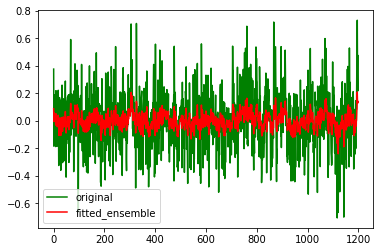

In [88]:
plt.plot(subject_ts[1][:,3][:1200],color='g',label='original')
plt.plot(ensemble_ts[3][0:1200],color='r',label='fitted_ensemble')
plt.legend()
plt.show()

In [86]:
pearsonr(ensemble_ts[3],subject_ts[1][:,3])[0]

0.8677375454524466

In [8]:
order_and_weight[3]

([(1, 1, 0),
  (1, 1, 1),
  (1, 1, 2),
  (1, 1, 3),
  (1, 1, 4),
  (1, 1, 5),
  (2, 1, 0),
  (2, 1, 1),
  (2, 1, 2),
  (2, 1, 3),
  (2, 1, 4),
  (2, 1, 5),
  (3, 1, 0),
  (3, 1, 1),
  (3, 1, 2),
  (3, 1, 3),
  (3, 1, 4),
  (3, 1, 5),
  (4, 1, 0),
  (4, 1, 1),
  (4, 1, 2),
  (4, 1, 3),
  (4, 1, 4),
  (4, 1, 5),
  (5, 1, 0),
  (5, 1, 1),
  (5, 1, 2),
  (5, 1, 3),
  (5, 1, 4),
  (5, 1, 5)],
 array([5.39314075e-46, 1.43902645e-10, 2.32095545e-01, 4.92615881e-19,
        3.46069216e-02, 1.95901396e-02, 2.11180724e-33, 4.09709410e-03,
        8.58626418e-02, 3.18184148e-02, 8.42301179e-18, 3.05745004e-13,
        1.43051026e-27, 4.20947361e-02, 3.36746269e-02, 2.72491811e-03,
        3.99491282e-01, 9.24928213e-03, 1.06382198e-24, 3.82792439e-02,
        1.01409417e-02, 2.40511690e-03, 1.89831219e-03, 7.79601377e-03,
        1.23869573e-23, 1.57867119e-02, 5.23755899e-03, 1.66884035e-03,
        1.59957035e-02, 5.48595409e-03]))

In [9]:
sub_orders_and_weights[3]

NameError: name 'sub_orders_and_weights' is not defined

In [35]:
file_dir = 'E:/projects/connectome/results/HurstExp_ARMA_results_0_to_5/ensemble_orders_and_weights'
file_names = listdir(file_dir)
file_names

['ensemble_orders_and_weights_100206.mat',
 'ensemble_orders_and_weights_100307.mat',
 'ensemble_orders_and_weights_100408.mat',
 'ensemble_orders_and_weights_100610.mat',
 'ensemble_orders_and_weights_101006.mat',
 'ensemble_orders_and_weights_101107.mat',
 'ensemble_orders_and_weights_101309.mat',
 'ensemble_orders_and_weights_101915.mat',
 'ensemble_orders_and_weights_102008.mat',
 'ensemble_orders_and_weights_102311.mat',
 'ensemble_orders_and_weights_102513.mat',
 'ensemble_orders_and_weights_102816.mat',
 'ensemble_orders_and_weights_103111.mat',
 'ensemble_orders_and_weights_103414.mat',
 'ensemble_orders_and_weights_103515.mat',
 'ensemble_orders_and_weights_103818.mat',
 'ensemble_orders_and_weights_104012.mat',
 'ensemble_orders_and_weights_104416.mat',
 'ensemble_orders_and_weights_104820.mat',
 'ensemble_orders_and_weights_105014.mat',
 'ensemble_orders_and_weights_105115.mat',
 'ensemble_orders_and_weights_105216.mat',
 'ensemble_orders_and_weights_105620.mat',
 'ensemble_

In [39]:
file_name= 'ensemble_orders_and_weights_100307.mat'
file = join(file_dir,file_name)
sub_orders_and_weights = scipy.io.loadmat(file)['ensemble_orders_and_weights']